## Import all libraries
 >Note that deepxde imports tensorflow already

In [1]:
import deepxde as dde
import numpy as np

Using backend: tensorflow.compat.v1

2022-05-23 11:34:21.092850: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-23 11:34:21.092894: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term



## Definition of the problem constants
- N_0 > Initial number of atoms
- dpy > decay rate [1/year]
- t_end > Time [year]

In [2]:
N_0 = 1
dpy = 0.693/28.8
t_end = 28.8

## Specification of the geometry
>Note that this example is only time dependent and has no space domain.

In [3]:
geom = dde.geometry.TimeDomain(0,t_end)

## We define the ODE 
Define the residual using Tensowrflow syntax.

$$
dN/dt = - \lambda * N(t)
$$

>Note that we need the implicit form here.

In [4]:
def ode(t, N):
    dN_t = dde.grad.jacobian(N, t)
    return (dN_t + (dpy * N))

## Add analytical solution
The analytical solution will only be displayed in the plots for visual comparison.\
This step is optional.
$$
N(t) = N_0 * exp(- \lambda * t)
$$

In [5]:
def func(t):
    return N_0 * np.exp(-dpy*t)

## Add initial condition
$$
N(0)=N_0
$$

In [6]:
ic = dde.icbc.IC(geom, lambda x:N_0, lambda _, on_initial: on_initial)

## Problem setup
Setup the Problem with the following input structure:

Problem (
```
1. computational geometry
2. ODE Residual
3. Initial condition
4. Nr of collocation points inside the domain
5. Nr of collocation points on the boundary
6. analytical solution
7. Nr of testing points inside the domain
```
)

In [7]:
data = dde.data.PDE(geom, ode, ic, num_domain=30, num_boundary=2, solution=func, num_test=40)

***

## Neuronal Network Setup
Set the Neuronal Network Parameters with the following input structure:

`([input] + [neurons] * Nr. of hidden layers + [output], "activation function", "Initializer")`

In [18]:
net = dde.nn.FNN([1] + [50]*1 + [1], "relu", "Glorot uniform")

## Union of Problem and Neural Network

In [19]:
model = dde.Model(data, net)

## Definition of training parameters/algorithm
Set the hyper-parameters for the optimization with the following input structure:

`(training algorithm, learning rate)`

In [20]:
#model.compile("adam", lr=0.001)
model.compile("L-BFGS")

Compiling model...
Building feed-forward neural network...
'build' took 0.051874 s

'compile' took 0.187471 s



/home/Alejandro/.local/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/Alejandro/.local/lib/python3.9/site-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


## Training of the model
Choose the `number of training epochs`.

In [21]:
#losshistory, train_state = model.train(epochs=20000)
losshistory, train_state = model.train()

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [5.87e-03, 1.00e+00]    [5.95e-03, 1.00e+00]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000030
  Number of iterations: 9
  Number of functions evaluations: 28
28        [3.03e-05, 4.01e-09]    [1.19e-05, 4.01e-09]    []  

Best model at step 28:
  train loss: 3.03e-05
  test loss: 1.19e-05
  test metric: []

'train' took 0.247569 s



## Plotting
The first plot is the train- and test loss in every epoch.

The second plot is the comparison between the analytical and the predicted solution in the train model chosen by adam optimization.

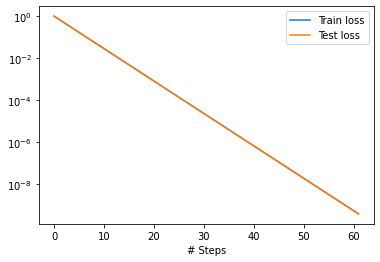

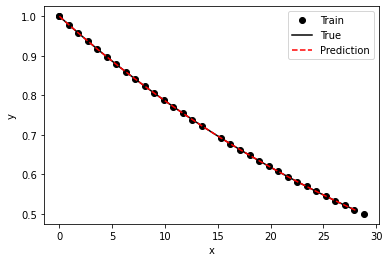

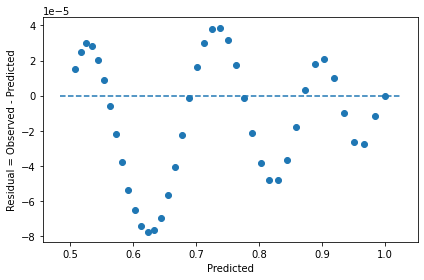

In [17]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)